In [160]:
import fiona
import geopandas as gpd
import pandas as pd
import shapely
from shapely import geometry
import json
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
import googlemaps
import time
from IPython.core.display import display, HTML
from IPython.display import IFrame
import re
from multiprocessing.dummy import Pool
from multiprocessing import cpu_count, freeze_support
from functools import partial
import ast 

In [2]:
#логер
def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display
    
    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = size / 200     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)
    
    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')

In [3]:
def getDataFromPage(url, driver):
#     print(url, driver)
    driver.get(url)
    time.sleep(4)
    
    ret_obj = {}
    
    ret_obj['url'] = url
    
    #title
    try:
        ret_obj['title'] = driver.find_element_by_css_selector('h1[class="x3AX1-LfntMc-header-title-title gm2-headline-5"] span').text
    except:
        ret_obj['title'] = ""
        
    #address
    try:
        ret_obj['address'] = driver.find_element_by_css_selector('div[class="QSFF4-text gm2-body-2"]').text
    except:
        ret_obj['address'] = ""
    
#     #rating
#     try:
#         ret_obj['rating'] = float(driver.find_element_by_css_selector('span.section-star-display').text.replace(',','.'))
#     except:
#         ret_obj['rating'] = 0
    
#     #review
#     try:
#         review_button = driver.find_element_by_css_selector('button.widget-pane-link[jsaction="pane.rating.moreReviews"]')
#         ret_obj['review_counts'] = int(re.search(r'\d+', review_button.text.replace(' ', ''))[0])
#     except:
#         ret_obj['review_counts'] = 0
        
    #category
    try:
        category_element = driver.find_element_by_css_selector('div[class="gm2-body-2"]')
        ret_obj['category'] = category_element.text
    except:
        try:
            category_element = driver.find_element_by_css_selector('h2[class="x3AX1-LfntMc-header-title-VdSJob"]') 
            ret_obj['category'] = category_element.text
        except:
            ret_obj['category'] = ""
    
    #review histogram
    try:
        hist = driver.find_elements_by_xpath('.//tr[contains(@class, "__histogram")]')
        if len(hist) == 5:
            reviews_hist = {
                "5": int(re.match(r'\d+', hist[0].get_attribute("aria-label").split(',')[1]).group(0)),
                "4": int(re.match(r'\d+', hist[1].get_attribute("aria-label").split(',')[1]).group(0)),
                "3": int(re.match(r'\d+', hist[2].get_attribute("aria-label").split(',')[1]).group(0)),
                "2": int(re.match(r'\d+', hist[3].get_attribute("aria-label").split(',')[1]).group(0)),
                "1": int(re.match(r'\d+', hist[4].get_attribute("aria-label").split(',')[1]).group(0)),
            }
            
            ret_obj['review_hist'] = reviews_hist
    except:
        ret_obj['reviews_hist'] = {}
    
    #popular times
    try:
        popular_times_days_sections = driver.find_elements_by_css_selector('div[class="O9Q0Ff-NmME3c-Utye1-haAclf"]')
    
#         counter = 0
#         days = ['Воскресенье', 'Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Cуббота']
#         poptimes = {}
        for day in popular_times_days_sections:
            ret_obj['popular_times_bars'] = [e.get_attribute("aria-label") for e in day.find_elements_by_css_selector('div.O9Q0Ff-NmME3c-Utye1-ZMv3u')]
#             poptimes[days[counter]] = pop_times_bars
#             counter+=1
#         ret_obj['popular_times_bars'] = pop_times_bars
           
    except Exception as e:
        ret_obj['popular_times_bars'] = {}
    
        
    return ret_obj

In [4]:
def google_scraping_func(url_list):
    driver = webdriver.Chrome('chromedriver.exe')
    
    for url in log_progress(url_list, 1):
        place = getDataFromPage(url, driver)
        places.append(place)
    
    return places

In [263]:
df = pd.read_csv('../data/raw_data.csv')

In [37]:
df.head()

,business_status,geometry,icon,icon_background_color,icon_mask_base_uri,name,photos,place_id,plus_code,rating,reference,scope,types,user_ratings_total,vicinity,opening_hours,price_level,lat,lon,url
0,OPERATIONAL,POINT (39.0925118 45.0370921),https://maps.gstatic.com/mapfiles/place_api/ic...,#4DB546,https://maps.gstatic.com/mapfiles/place_api/ic...,Сквер «Субботний»,"[{'height': 2250, 'html_attributions': ['<a hr...",ChIJ1wuQEOda8EARP7B99phyQNc,"{'compound_code': '23PV+R2 Krasnodar', 'global...",3.7,ChIJ1wuQEOda8EARP7B99phyQNc,GOOGLE,"['park', 'point_of_interest', 'establishment']",3,"Ulitsa Ural'skaya, 158, Krasnodar",NaN,NaN,45.037092,39.092512,https://www.google.com/maps/place/?q=place_id:...
1,OPERATIONAL,POINT (39.097586 45.0420204),https://maps.gstatic.com/mapfiles/place_api/ic...,#4DB546,https://maps.gstatic.com/mapfiles/place_api/ic...,Сквер «Субботний»,NaN,ChIJ1wuQEOda8EARJS-lBjJCrCI,"{'compound_code': '23RX+R2 Krasnodar', 'global...",0.0,ChIJ1wuQEOda8EARJS-lBjJCrCI,GOOGLE,"['park', 'point_of_interest', 'establishment']",0,"Ulitsa Ural'skaya, 158, Krasnodar",NaN,NaN,45.042020,39.097586,https://www.google.com/maps/place/?q=place_id:...
2,OPERATIONAL,POINT (39.0955591 45.0224408),https://maps.gstatic.com/mapfiles/place_api/ic...,#4DB546,https://maps.gstatic.com/mapfiles/place_api/ic...,Skver,"[{'height': 4320, 'html_attributions': ['<a hr...",ChIJ1-XXYIla8EAR6qWh11NYY8A,"{'compound_code': '23CW+X6 Krasnodar', 'global...",4.4,ChIJ1-XXYIla8EAR6qWh11NYY8A,GOOGLE,"['park', 'point_of_interest', 'establishment']",666,"к, Ulitsa Kirova, 183к2, Krasnodar",{'open_now': True},NaN,45.022441,39.095559,https://www.google.com/maps/place/?q=place_id:...
3,OPERATIONAL,POINT (39.0382741 45.07198229999999),https://maps.gstatic.com/mapfiles/place_api/ic...,#4DB546,https://maps.gstatic.com/mapfiles/place_api/ic...,Skver Serdtse Gubernskogo,NaN,ChIJr4MvRudF8EARPAAyBpE8PcU,"{'compound_code': '32CQ+Q8 Krasnodar', 'global...",5.0,ChIJr4MvRudF8EARPAAyBpE8PcU,GOOGLE,"['park', 'point_of_interest', 'establishment']",5,"Ulitsa Dombayskaya, 15, Krasnodar",NaN,NaN,45.071982,39.038274,https://www.google.com/maps/place/?q=place_id:...
4,OPERATIONAL,POINT (39.1035563 45.0129496),https://maps.gstatic.com/mapfiles/place_api/ic...,#7B9EB0,https://maps.gstatic.com/mapfiles/place_api/ic...,Ботанический сад 1/ КубГУ,NaN,ChIJj1KR7K5b8EAR2sEDSquYAtU,"{'compound_code': '2473+5C Krasnodar', 'global...",4.0,ChIJj1KR7K5b8EAR2sEDSquYAtU,GOOGLE,"['university', 'point_of_interest', 'establish...",2,"Ulitsa Gogolya, 92, Krasnodar",NaN,NaN,45.012950,39.103556,https://www.google.com/maps/place/?q=place_id:...


Места с наличием отзывов (рейтинга)

In [56]:
df.loc[(~df.rating.isna())].shape[0]

(8329, 21)

In [81]:
set(df['types'].apply(lambda s: list(ast.literal_eval(s))).explode().value_counts().keys()) - \
set(df.loc[(~df.rating.isna()), 'types'].apply(lambda s: list(ast.literal_eval(s))).explode().value_counts().keys())

{'locality',
 'neighborhood',
 'political',
 'sublocality',
 'sublocality_level_1',
 'sublocality_level_2'}

In [7]:
places_df = pd.read_csv('../data/places_GP_temp.csv')

In [264]:
places = []

In [265]:
datalist = df.loc[~df.url.isin(places_df.url), 'url']

if __name__== "__main__":
    freeze_support()
    pool = Pool()

    # max number of parallel process
    ITERATION_COUNT = cpu_count()-1 if len(datalist) >= cpu_count()-1 else len(datalist)

    count_per_iteration = len(datalist) / float(ITERATION_COUNT)

    for i in range(0, ITERATION_COUNT):
        list_start = int(count_per_iteration * i)
        list_end = int(count_per_iteration * (i+1))
        pool.apply_async(google_scraping_func, [datalist[list_start:list_end]])

In [266]:
df_p = pd.DataFrame(places)
df_p.shape

(802, 5)

## Проверка сколько осталось

In [336]:
df_p = pd.DataFrame(places)
size = df_p.shape[0]
end = 0
for i in range(0,60):
    df_p = pd.DataFrame(places)
    end = df_p.shape[0]
    time.sleep(1)
end-size

43

In [365]:
len(df.loc[~df.url.isin(df_p.url)]),len(df.loc[~df.url.isin(gdf.url)])/(end-size)

(96, 4.1395348837209305)

## Создание датасета

In [267]:
gdf = gpd.GeoDataFrame(df_p.merge(df[['url', 'geometry', 'types', 'rating', 'user_ratings_total']]))

In [268]:
gdf.geometry = [shapely.wkt.loads(r['geometry']) for i, r in gdf.iterrows()]

In [269]:
gdf.drop_duplicates('url', inplace = True)

In [262]:
places_df.to_csv('../data/places_GP_temp.csv', index = False)

In [14]:
gdf.drop(columns = 'reviews_hist', inplace = True)

KeyError: "['reviews_hist'] not found in axis"

In [85]:
gdf

,url,title,address,category,popular_times_bars,geometry,types,rating,user_ratings_total
0,https://www.google.com/maps/place/?q=place_id:...,,Об этих данных,,NaN,None,NaN,NaN,NaN
1,https://www.google.com/maps/place/?q=place_id:...,"Новый век, СФ","ул. Демуса, 60, Краснодар, Краснодарский край,...",Строительная компания,NaN,None,NaN,NaN,NaN
2,https://www.google.com/maps/place/?q=place_id:...,Магазин автоприцепов,"ул. Ростовское ш., 24/1, Краснодар, Краснодарс...",Продажа прицепов,NaN,None,NaN,NaN,NaN
3,https://www.google.com/maps/place/?q=place_id:...,Pepe магазин детской одежды,"Краснодар, Краснодарский край, 350901",Магазин одежды,NaN,None,NaN,NaN,NaN
4,https://www.google.com/maps/place/?q=place_id:...,Трейд Инвест,"ул. Тихорецкая, 8, Краснодар, Краснодарский кр...",Оптовая продажа строительных материалов,NaN,None,NaN,NaN,NaN
5,https://www.google.com/maps/place/?q=place_id:...,Первый Риэлт Центр,"Краснодар, Краснодарский край, 350000",Агентство недвижимости,NaN,None,NaN,NaN,NaN
6,https://www.google.com/maps/place/?q=place_id:...,ТРАНСПОРТ ТВ,"ул. ш. Нефтяников, 18, Краснодар, Краснодарски...",Офис компании,NaN,None,NaN,NaN,NaN
7,https://www.google.com/maps/place/?q=place_id:...,Олимпия,"ул. Крупской, 22, Краснодар, Краснодарский кра...",,NaN,None,NaN,NaN,NaN
8,https://www.google.com/maps/place/?q=place_id:...,AWP-Group,"158 - 15 Stasova Str., Краснодар, Краснодарски...",,NaN,None,NaN,NaN,NaN
9,https://www.google.com/maps/place/?q=place_id:...,Репетиторский Центр,"ул. Измаильская, 74 к 4, Краснодар, Краснодарс...",Образовательный центр,NaN,None,NaN,NaN,NaN


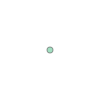

In [255]:
gdf.loc[0, 'geometry']

In [270]:
places_df = pd.concat([places_df.loc[~places_df.url.isin(gdf.url)], gdf], ignore_index=True ).drop_duplicates('url')

## Карта
На месте пустоты - кладбище

In [136]:
places_df['geometry'] = places_df.geometry.astype(str)

C:\Users\yupes\anaconda3\envs\python-gis\lib\site-packages\geopandas\geodataframe.py:1350: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


In [137]:
places_df.geometry = [shapely.wkt.loads(r['geometry']) for i, r in places_df.iterrows()]

<AxesSubplot:>

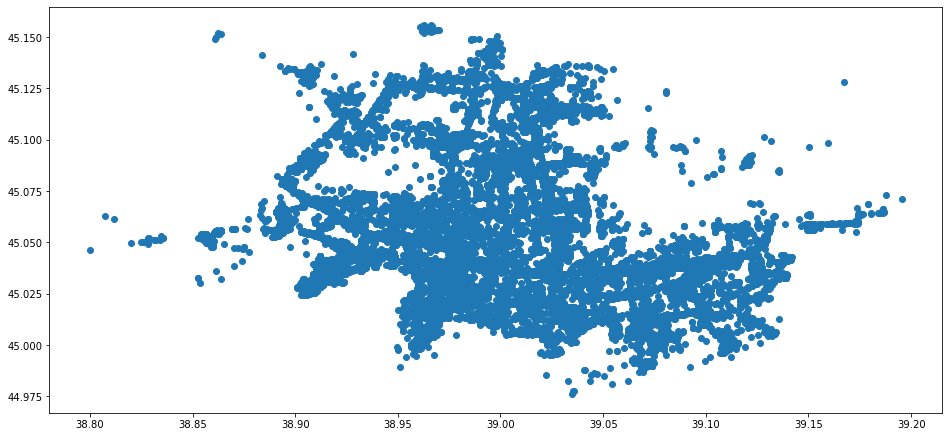

In [294]:
places_df.plot(figsize = (16, 15))

## Статистика

Топ-20 по отзывам

In [273]:
places_df.sort_values('user_ratings_total', ascending = False)[:20]

,url,title,address,category,popular_times_bars,geometry,types,rating,user_ratings_total
1610,https://www.google.com/maps/place/?q=place_id:...,Парк «Краснодар»,"Краснодар, Краснодарский край, 350059",Парк,"['Загруженность в 04:00: 0%.', 'Загруженность ...",POINT (39.03178 45.04164),"['park', 'tourist_attraction', 'point_of_inter...",4.9,35831.0
15427,https://www.google.com/maps/place/?q=place_id:...,Красная Площадь,"ул. Дзержинского, 100, Краснодар, Краснодарски...",Торговый центр,"[Загруженность в 06:00: 0%., Загруженность в 0...",POINT (38.98362 45.10213),"['shopping_mall', 'point_of_interest', 'establ...",4.7,27497.0
1617,https://www.google.com/maps/place/?q=place_id:...,"Стадион ФК ""Краснодар""","ул. Разведчика Леонова, 1, Краснодар, Краснода...",Стадион,NaN,POINT (39.02919 45.04449),"['stadium', 'gym', 'health', 'point_of_interes...",4.9,25865.0
15200,https://www.google.com/maps/place/?q=place_id:...,Чистяковская Роща,"ул. Колхозная, Краснодар, Краснодарский край, ...",Парк,"[Загруженность в 04:00: 1%., Загруженность в 0...",POINT (38.99404 45.05765),"['park', 'tourist_attraction', 'point_of_inter...",4.6,20277.0
8022,https://www.google.com/maps/place/?q=place_id:...,Бауцентр,"ул. Ростовское ш., 28 корпус 7, Краснодар, Кра...",Магазин строительных товаров,"['Загруженность в 06:00: 0%.', 'Загруженность ...",POINT (38.99397 45.09639),"['hardware_store', 'park', 'point_of_interest'...",4.5,12139.0
13895,https://www.google.com/maps/place/?q=place_id:...,Гипер Лента,"ул. Российская, 257, Краснодар, Краснодарский ...",Гипермаркет,"['Загруженность в 04:00: 1%.', 'Загруженность ...",POINT (39.01224 45.08723),"['supermarket', 'grocery_or_supermarket', 'foo...",4.3,11592.0
15269,https://www.google.com/maps/place/?q=place_id:...,Парк культуры и отдыха имени 30-летия Победы,"ул. Береговая, 146, Краснодар, Краснодарский к...",Парк,"[Загруженность в 04:00: 0%., Загруженность в 0...",POINT (38.95178 45.01697),"['park', 'tourist_attraction', 'point_of_inter...",4.6,8236.0
10675,https://www.google.com/maps/place/?q=place_id:...,Лента,"ул. Восточный обход, 19, Краснодар, Краснодарс...",Гипермаркет,"['Загруженность в 04:00: 1%.', 'Загруженность ...",POINT (39.12662 45.03775),"['supermarket', 'grocery_or_supermarket', 'foo...",4.4,7836.0
2741,https://www.google.com/maps/place/?q=place_id:...,Солнечный остров,"Краснодар, Краснодарский край, 350002",Парк развлечений,"['Загруженность в 04:00: 1%.', 'Загруженность ...",POINT (39.05438 45.00731),"['amusement_park', 'tourist_attraction', 'poin...",4.6,7730.0
11792,https://www.google.com/maps/place/?q=place_id:...,Бауцентр,"ул. Селезнева, 4, Краснодар, Краснодарский кра...",Магазин строительных товаров,"['Загруженность в 06:00: 0%.', 'Загруженность ...",POINT (39.02041 45.02747),"['park', 'point_of_interest', 'store', 'establ...",4.4,7462.0


Поиск обязательных аттракторов: 

Присутствуют:
+ Парк Краснодар (Галицкого) 	Близко к району проектирования, современный парк, - нельзя с собаками
+ Парк Солнечный остров	Требует ухода, есть пляж, проблема с вывозом мусора
+ Сафари-парк	Зоопарк на территории с солнечного острова, запущенный
+ Парк 30-летия Победы	Военный музей, набережная реки Кубань
+ Парк Рождественский	Место «пикников», неблагоустроенный 
+ Старая Кубань	Пляж, грязный, грязная река
+ Сквер Дружбы	Ухоженный сквер в центре, многолюдный
+ Ботанический сад им. профессора И. С. Косенко Ухоженный, уютный
+ Чистяковская роща	Много зелени, несколько запущенный 
+ Сквер им. Маршала Г.К. Жукова	Маленький уютный сквер, напротив администрации
- Городской сад	Исторический парк, проблемы с аттракционом
- Городской сад	Парк в начале Красной улицы, нравится горожанам
- Учебный Ботанический Сад	Иногда открыт только для экскурсий (Ботанический сад 1/ КубГУ)

In [96]:
places_df.address.fillna('', inplace = True)

In [141]:
places_df.loc[places_df.title.str.contains('Ботан')]

,url,title,address,category,popular_times_bars,geometry,types,rating,user_ratings_total
6619,https://www.google.com/maps/place/?q=place_id:...,Ботаника,"ул. имени героя Владислава Посадского, 36, Кра...",Доставка цветов,NaN,POINT (39.03995 45.04652),"['point_of_interest', 'establishment']",NaN,NaN
8222,https://www.google.com/maps/place/?q=place_id:...,Ботаника Фермерские продукты,"ул. Дзержинского, 100к1, Краснодар, Краснодарс...",Продовольственный магазин,NaN,POINT (38.98591 45.10172),"['grocery_or_supermarket', 'food', 'point_of_i...",NaN,NaN
13297,https://www.google.com/maps/place/?q=place_id:...,Ботаника,"ул. 40-летия Победы, 87, Краснодар, Краснодарс...",Цветочный магазин,NaN,POINT (39.02477 45.05592),"['florist', 'point_of_interest', 'store', 'est...",4.7,26.0
15198,https://www.google.com/maps/place/?q=place_id:...,Ботанический сад им. И.С. Косенко (Дендрарий),"ул. Калинина, 13, Краснодар, Краснодарский кра...",Ботанический сад,"[Загруженность в 05:00: 0%., Загруженность в 0...",POINT (38.92933 45.05415),"['tourist_attraction', 'park', 'point_of_inter...",4.8,5265.0
15284,https://www.google.com/maps/place/?q=place_id:...,Ботанический сад 1/ КубГУ,"ул. Гоголя, 92, Краснодар, Краснодарский край,...",Университет,NaN,POINT (39.10356 45.01295),"['university', 'point_of_interest', 'establish...",4.0,2.0


# Возможные категории

Можно выделить доп категории: магазин, здоровье, машины, еда, школа, услуги

In [274]:
places_df['types'].apply(lambda s: list(ast.literal_eval(s))).explode().str.split('_').explode().value_counts().reset_index().to_csv('../data/types.csv', index = False)

In [275]:
places_df.loc[places_df.category != '','category'].str.lower().explode().str.split(' ').explode().value_counts().reset_index().to_csv('../data/category.csv', index = False)

In [331]:
places_df['types'].apply(lambda s: list(ast.literal_eval(s))).explode().value_counts().reset_index().to_csv('../data/types_GP.csv')

In [277]:
places_df.loc[places_df.category != '','category'].str.lower().value_counts().reset_index().to_csv('../data/category_GP.csv', index = False)

Магазины

In [301]:
places_df.loc[(places_df.title.str.lower().str.contains('магазин'))|(places_df.category.str.lower().str.contains('магазин')) |(places_df.types.str.contains('store'))]

,url,title,address,category,popular_times_bars,geometry,types,rating,user_ratings_total
2,https://www.google.com/maps/place/?q=place_id:...,Магазин автоприцепов,"ул. Ростовское ш., 24/1, Краснодар, Краснодарс...",Продажа прицепов,NaN,POINT (38.99111 45.08963),"['point_of_interest', 'store', 'establishment']",4.5,2.0
3,https://www.google.com/maps/place/?q=place_id:...,Pepe магазин детской одежды,"Краснодар, Краснодарский край, 350901",Магазин одежды,NaN,POINT (39.03829 45.07438),"['point_of_interest', 'establishment']",NaN,NaN
11,https://www.google.com/maps/place/?q=place_id:...,Кубаночка,"ул. Нахимова, 2к1, Краснодар, Краснодарский кр...",Мясной магазин,"[Загруженность в 06:00: 0%., Загруженность в 0...",POINT (38.97724 45.09235),"['food', 'point_of_interest', 'store', 'establ...",5.0,1.0
16,https://www.google.com/maps/place/?q=place_id:...,Магнит,"ул. Уральская, 184/2, Краснодар, Краснодарский...",Продовольственный магазин,"['Загруженность в 06:00: 0%.', 'Загруженность ...",POINT (39.10433 45.04238),"['grocery_or_supermarket', 'food', 'point_of_i...",4.2,237.0
17,https://www.google.com/maps/place/?q=place_id:...,MOHITO,"Крылатая ул., 2, Краснодар, Краснодарский край...",Магазин женской одежды,NaN,POINT (39.12202 45.01224),"['point_of_interest', 'clothing_store', 'store...",4.7,13.0
...,...,...,...,...,...,...,...,...,...
16279,https://www.google.com/maps/place/?q=place_id:...,Хлебная улица,"ул. Стасова, 88/1, цоколь 1, Краснодар, Красно...",Кафе,"[Загруженность в 06:00: 0%., Загруженность в 0...",POINT (39.03277 45.00836),"['cafe', 'bakery', 'food', 'point_of_interest'...",4.4,27.0
16289,https://www.google.com/maps/place/?q=place_id:...,KristAl,"пр. Чекистов, 33/1, Краснодар, Краснодарский к...",Кондитерская,"[Загруженность в 06:00: 0%., Загруженность в 0...",POINT (38.91984 45.03503),"['bakery', 'cafe', 'food', 'point_of_interest'...",4.8,97.0
16291,https://www.google.com/maps/place/?q=place_id:...,Art Love Cafe,"ул. Героя Сарабеева, 3/1, Краснодар, Краснодар...",Кофейня,NaN,POINT (39.03060 45.05172),"['cafe', 'food', 'point_of_interest', 'store',...",0.0,0.0
16295,https://www.google.com/maps/place/?q=place_id:...,Осетинский Дворик,"ул. Селезнева, 201, Краснодар, Краснодарский к...",Кафе,NaN,POINT (39.05515 45.01503),"['cafe', 'meal_delivery', 'bakery', 'food', 'p...",4.3,47.0


Здоровье

In [302]:
places_df.loc[places_df.types.str.contains('health')]

,url,title,address,category,popular_times_bars,geometry,types,rating,user_ratings_total
18,https://www.google.com/maps/place/?q=place_id:...,Здоровый Мир,"ул. Захарова, 25, Краснодар, Краснодарский кра...",Аптека,NaN,POINT (38.96666 45.00617),"['pharmacy', 'health', 'point_of_interest', 's...",5.0,2.0
25,https://www.google.com/maps/place/?q=place_id:...,Медицинская лаборатория CL,"ул. Уральская, 166/2, Краснодар, Краснодарский...",Медицинская лаборатория,NaN,POINT (39.09605 45.04058),"['health', 'point_of_interest', 'establishment']",3.2,5.0
38,https://www.google.com/maps/place/?q=place_id:...,"Клуб спортивных единоборств ""Комсомолец СПОРТ""","ул. 30 Иркутской Дивизии, 11/2, Краснодар, Кра...",Школа боевых искусств,NaN,POINT (39.10206 45.03883),"['health', 'point_of_interest', 'establishment']",5.0,13.0
41,https://www.google.com/maps/place/?q=place_id:...,Краевой центр охраны здоровья семьи и репродукции,"площадь Победы, 1, Краснодар, Краснодарский кр...",Центр планирования семьи,NaN,POINT (38.96894 45.01255),"['health', 'point_of_interest', 'establishment']",4.3,17.0
46,https://www.google.com/maps/place/?q=place_id:...,Отделение Реанимации И Интенсивной Терапии Нов...,"пл. Победы, ул, корпус 1, Краснодар, Краснодар...",Отделение больницы,NaN,POINT (38.96869 45.01203),"['health', 'point_of_interest', 'establishment']",5.0,1.0
...,...,...,...,...,...,...,...,...,...
15481,https://www.google.com/maps/place/?q=place_id:...,Салон красоты ЛАКИ LIFE,"ул. Кубанская набережная, 39/1, Краснодар, Кра...",Салон красоты,NaN,POINT (38.95950 45.02730),"['beauty_salon', 'hair_care', 'spa', 'health',...",4.8,22.0
15518,https://www.google.com/maps/place/?q=place_id:...,Лечебно-диагностический центр. Клиника Екатери...,"ул. Кубанская набережная, 37/1, Краснодар, Кра...",Медицинский центр,NaN,POINT (38.95920 45.02507),"['hospital', 'dentist', 'doctor', 'health', 'p...",3.4,150.0
15524,https://www.google.com/maps/place/?q=place_id:...,"Ригла, ООО, сеть аптек","ул. Кубанская набережная, 25А, Краснодар, Крас...",Аптека,"[Загруженность в 04:00: 0%., Загруженность в 0...",POINT (38.95944 45.02194),"['pharmacy', 'health', 'point_of_interest', 's...",2.3,9.0
15771,https://www.google.com/maps/place/?q=place_id:...,"Кафе ""На Малине""",,,"[Загруженность в 04:00: 40%., Загруженность в ...",POINT (38.98680 45.02178),"['cafe', 'spa', 'lodging', 'food', 'health', '...",4.2,71.0


Можем говорить о том, что все спортзалы (gym) относятся к категории здоровья

In [282]:
places_df.loc[places_df.types.str.contains('gym'), 'types'].apply(lambda s: list(ast.literal_eval(s))).explode().str.split('_').explode().value_counts()[:20]

gym              111
point            111
of               111
interest         111
establishment    111
health           111
spa               11
bar                4
night              3
club               3
lodging            3
food               2
salon              2
beauty             2
hospital           2
restaurant         2
store              1
stadium            1
hair               1
care               1
Name: types, dtype: int64

In [154]:
places_df.category.fillna('', inplace = True)

Парк

In [283]:
places_df.loc[(places_df.category.str.lower().str.contains('парк'))]

,url,title,address,category,popular_times_bars,geometry,types,rating,user_ratings_total
253,https://www.google.com/maps/place/?q=place_id:...,"Городской сад, парк культуры и отдыха","ул. Постовая, 34, Краснодар, Краснодарский кра...",Парк,"['Загруженность в 06:00: 0%.', 'Загруженность ...",POINT (38.96992 45.01055),"['park', 'tourist_attraction', 'point_of_inter...",4.6,6826.0
634,https://www.google.com/maps/place/?q=place_id:...,Сафари-Парк,"ул. Трамвайная, 2, Краснодар, Краснодарский кр...",Зоопарк,"['Загруженность в 06:00: 0%.', 'Загруженность ...",POINT (39.05494 45.00896),"['zoo', 'tourist_attraction', 'point_of_intere...",4.4,4344.0
645,https://www.google.com/maps/place/?q=place_id:...,Зоопарк,"ул. Трамвайная, 2, Краснодар, Краснодарский кр...",Зоопарк,"['Загруженность в 06:00: 0%.', 'Загруженность ...",POINT (39.05489 45.00895),"['zoo', 'tourist_attraction', 'point_of_intere...",4.4,133.0
674,https://www.google.com/maps/place/?q=place_id:...,Грибок,"ул. Трамвайная, 2, Краснодар, Краснодарский кр...",Парк аттракционов,NaN,POINT (39.05279 45.01028),"['point_of_interest', 'establishment']",4.5,20.0
689,https://www.google.com/maps/place/?q=place_id:...,Велопрокат «Два колеса»,"ул. Трамвайная, 2 строение 8, Краснодар, Красн...",Велопарковка,NaN,POINT (39.05548 45.00802),"['point_of_interest', 'establishment']",NaN,NaN
...,...,...,...,...,...,...,...,...,...
15307,https://www.google.com/maps/place/?q=place_id:...,Сквер Сердце Губернского,"ул. Домбайская, 15, Краснодар, Краснодарский к...",Парк,NaN,POINT (39.03827 45.07198),"['park', 'point_of_interest', 'establishment']",5.0,5.0
15308,https://www.google.com/maps/place/?q=place_id:...,Александровский бульвар,"ул. Красная, 149, Краснодар, Краснодарский кра...",Парк,"[Загруженность в 04:00: 1%., Загруженность в 0...",POINT (38.97882 45.04829),"['park', 'point_of_interest', 'establishment']",4.7,228.0
15309,https://www.google.com/maps/place/?q=place_id:...,Солнечный парк,"ул. Солнечная, 17к1, Краснодар, Краснодарский ...",Парк,"[Загруженность в 04:00: 1%., Загруженность в 0...",POINT (39.00738 45.07237),"['park', 'point_of_interest', 'establishment']",4.7,806.0
15310,https://www.google.com/maps/place/?q=place_id:...,Колесо обозрения,"ул. Захарова, Краснодар, Краснодарский край, 3...",Парк аттракционов,"[Загруженность в 06:00: 0%., Загруженность в 0...",POINT (38.97061 45.01352),"['point_of_interest', 'establishment']",4.3,204.0


In [284]:
places_df.loc[(places_df.category.str.lower().str.contains('сад'))].category.value_counts()

Детский сад                        187
Магазин товаров для дачи и сада     11
Товары и услуги для садоводства      4
Сад                                  4
Магазин садового оборудования        3
Ботанический сад                     2
Магазин садовой мебели               1
Фруктовый сад                        1
Name: category, dtype: int64

In [285]:
places_df.loc[places_df.types.str.contains('stadium')]

,url,title,address,category,popular_times_bars,geometry,types,rating,user_ratings_total
206,https://www.google.com/maps/place/?q=place_id:...,КСК,"ул. Камвольная, 8, Краснодар, Краснодарский кр...",Стадион,NaN,POINT (39.06804 45.02338),"['stadium', 'point_of_interest', 'establishment']",4.6,445.0
1617,https://www.google.com/maps/place/?q=place_id:...,"Стадион ФК ""Краснодар""","ул. Разведчика Леонова, 1, Краснодар, Краснода...",Стадион,NaN,POINT (39.02919 45.04449),"['stadium', 'gym', 'health', 'point_of_interes...",4.9,25865.0
8120,https://www.google.com/maps/place/?q=place_id:...,Cтадион Академии ФК «Краснодар»,"ул. Жлобы, 114, Краснодар, Краснодарский край,...",Стадион,NaN,POINT (39.03835 45.04954),"['stadium', 'point_of_interest', 'establishment']",NaN,NaN
12928,https://www.google.com/maps/place/?q=place_id:...,стадион КубГАУ,"ул. Калинина, 13, Краснодар, Краснодарский кра...",Стадион,NaN,POINT (38.92303 45.04790),"['stadium', 'point_of_interest', 'establishment']",4.7,58.0
15329,https://www.google.com/maps/place/?q=place_id:...,УСЦ Покровские озера,"Краснодар, Краснодарский край, 350038",Стадион,NaN,POINT (39.00131 45.02933),"['stadium', 'point_of_interest', 'establishment']",4.6,207.0


Определение улиц с большим числом категории еда

In [314]:
food_streets = places_df.loc[places_df.types.str.contains('food'), 'address'].str.split(',').explode().str.lower().str.strip().value_counts().reset_index()

In [320]:
places_df.loc[places_df.types.str.contains('natural_feature')]

,url,title,address,category,popular_times_bars,geometry,types,rating,user_ratings_total
15312,https://www.google.com/maps/place/?q=place_id:...,оз. Копанка,"Краснодар, Краснодарский край, 350087",Озеро,NaN,POINT (39.02339 45.10672),"['natural_feature', 'establishment']",3.8,5.0
15319,https://www.google.com/maps/place/?q=place_id:...,оз. Карасун,"Краснодар, Краснодарский край",Озеро,NaN,POINT (39.10449 45.03604),"['natural_feature', 'establishment']",5.0,6.0
15321,https://www.google.com/maps/place/?q=place_id:...,Покровское оз.,"Краснодар, Краснодарский край",Озеро,NaN,POINT (38.99397 45.02729),"['natural_feature', 'establishment']",4.3,14.0
15332,https://www.google.com/maps/place/?q=place_id:...,Кубань,"Республика Адыгея, 385110",Озеро,NaN,POINT (39.03466 44.97598),"['natural_feature', 'establishment']",5.0,1.0
15341,https://www.google.com/maps/place/?q=place_id:...,Стар. Кубань,"Краснодар, Краснодарский край, 350058",Озеро,NaN,POINT (39.05429 45.00892),"['natural_feature', 'establishment']",4.4,14.0
15342,https://www.google.com/maps/place/?q=place_id:...,зат. Старица,"Краснодар, Краснодарский край, 350001",Озеро,NaN,POINT (39.00542 45.00759),"['natural_feature', 'establishment']",4.6,5.0
15344,https://www.google.com/maps/place/?q=place_id:...,оз. Карасун,"Краснодар, Краснодарский край, 350018",Озеро,NaN,POINT (39.06528 45.01363),"['natural_feature', 'establishment']",4.0,1.0
15349,https://www.google.com/maps/place/?q=place_id:...,оз. Карасун,"Краснодар, Краснодарский край",Озеро,NaN,POINT (39.06735 45.01441),"['natural_feature', 'establishment']",3.0,1.0
15354,https://www.google.com/maps/place/?q=place_id:...,оз. Карасун,"Краснодар, Краснодарский край",Озеро,NaN,POINT (39.09427 45.02627),"['natural_feature', 'establishment']",5.0,1.0
15356,https://www.google.com/maps/place/?q=place_id:...,Пруд Карасун,"Краснодар, Краснодарский край, 350033",Озеро,NaN,POINT (38.99139 45.02694),"['natural_feature', 'establishment']",3.4,5.0


In [287]:
food_streets.loc[(~food_streets['index'].str.contains('ул')) & (~food_streets['index'].str.isnumeric())][3:40]

,index,address
45,пр. чекистов,23
82,знаменский,12
83,остановочный комплекс,12
129,"трц ""красная площадь""",7
137,1 этаж,7
139,свх краснодарский 4 отделение,7
142,пр. репина,7
147,79/1,6
161,8 корпус 1,6
165,кружевная,6


In [291]:
food_streets = places_df.loc[places_df.types.str.contains('restaurant'), 'address'].str.split(',').explode().str.lower().str.strip().value_counts().reset_index()
food_streets.loc[(~food_streets['index'].str.contains('ул')) & (~food_streets['index'].str.isnumeric())][3:40]

,index,address
33,пр. чекистов,12
85,79/1,4
88,8 корпус 1,4
119,3 этаж,3
120,"трц ""красная площадь""",3
148,лента,3
149,9/1,3
157,2 этаж,3
184,59/1,2
193,2/2,2


<AxesSubplot:>

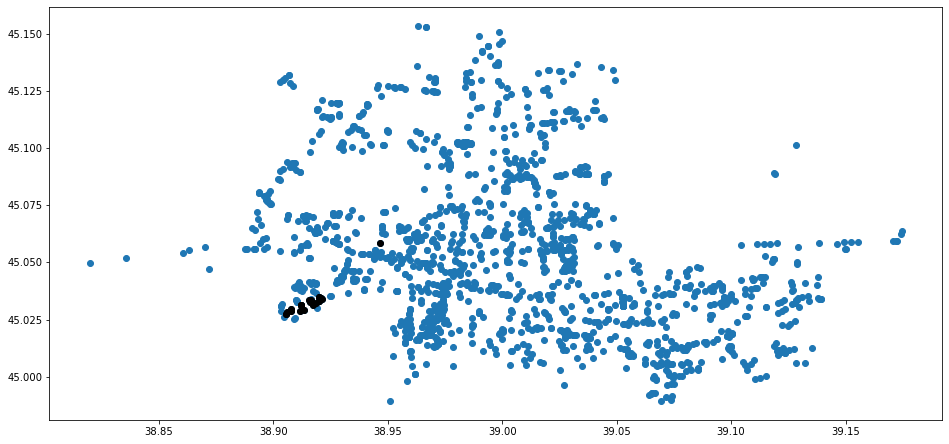

In [296]:
ax = places_df.loc[places_df.types.str.contains('food')].plot(figsize = (16, 15))
places_df.loc[(places_df.types.str.contains('food')) &places_df.address.str.lower().str.contains('чекистов')].plot(ax = ax, color = 'k')

In [325]:
places_df.loc[(places_df.types.str.contains('restaurant'))|(places_df.types.str.contains('cafe'))|(places_df.types.str.contains('bar'))]

,url,title,address,category,popular_times_bars,geometry,types,rating,user_ratings_total
66,https://www.google.com/maps/place/?q=place_id:...,Шашлычный двор,"ул. Тюляева, 43, Краснодар, Краснодарский край...",Ресторан,NaN,POINT (39.09605 45.03961),"['restaurant', 'food', 'point_of_interest', 'e...",4.2,176.0
132,https://www.google.com/maps/place/?q=place_id:...,KFC,"ул. Александра Покрышкина, д. 3, Краснодар, Кр...",Фастфуд,"['Загруженность в 06:00: 0%.', 'Загруженность ...",POINT (38.94979 45.10791),"['restaurant', 'food', 'point_of_interest', 'e...",2.3,27.0
168,https://www.google.com/maps/place/?q=place_id:...,Палитра Суши,"Кружевная, 5, Краснодар, Краснодарский край, 3...",Суши,NaN,POINT (39.06546 44.99295),"['restaurant', 'food', 'point_of_interest', 'e...",NaN,NaN
169,https://www.google.com/maps/place/?q=place_id:...,Flat White Flat,"Конгрессная, 23, Краснодар, Краснодарский край...",Кофейня,NaN,POINT (38.96242 45.10723),"['cafe', 'food', 'point_of_interest', 'store',...",4.5,2.0
199,https://www.google.com/maps/place/?q=place_id:...,RAI-SPA,,,"['Загруженность в 04:00: 87%.', 'Загруженность...",POINT (39.01081 45.01105),"['night_club', 'spa', 'lodging', 'bar', 'healt...",4.8,283.0
...,...,...,...,...,...,...,...,...,...
16324,https://www.google.com/maps/place/?q=place_id:...,MagicHall,"ул. Рашпилевская, 57/1, Краснодар, Краснодарск...",Ресторан,NaN,POINT (38.96867 45.02634),"['restaurant', 'food', 'point_of_interest', 'e...",4.5,38.0
16325,https://www.google.com/maps/place/?q=place_id:...,Shooba-Dooba bar,"ул. Красная, 76а, Краснодар, Краснодарский кра...",Бар,NaN,POINT (38.97228 45.02887),"['bar', 'point_of_interest', 'establishment']",4.6,14.0
16326,https://www.google.com/maps/place/?q=place_id:...,Баку,"Краснодар, Краснодарский край, 350912",Ресторан,"[Загруженность в 06:00: 0%., Загруженность в 0...",POINT (39.12639 45.04167),"['restaurant', 'food', 'point_of_interest', 'e...",4.2,265.0
16327,https://www.google.com/maps/place/?q=place_id:...,Ассорти Востока,"ул. Советская, 4, Яблоновский, Республика Адыг...",Кафе,NaN,POINT (38.95092 44.98945),"['cafe', 'food', 'point_of_interest', 'establi...",4.4,37.0


In [330]:
places_df.loc[~((places_df.types.str.contains('store')) |(places_df.types.str.contains('market')) ) & ((places_df.types.str.contains('bakery'))|(places_df.types.str.contains('restaurant'))|(places_df.types.str.contains('cafe'))|(places_df.types.str.contains('bar')))]

,url,title,address,category,popular_times_bars,geometry,types,rating,user_ratings_total
66,https://www.google.com/maps/place/?q=place_id:...,Шашлычный двор,"ул. Тюляева, 43, Краснодар, Краснодарский край...",Ресторан,NaN,POINT (39.09605 45.03961),"['restaurant', 'food', 'point_of_interest', 'e...",4.2,176.0
132,https://www.google.com/maps/place/?q=place_id:...,KFC,"ул. Александра Покрышкина, д. 3, Краснодар, Кр...",Фастфуд,"['Загруженность в 06:00: 0%.', 'Загруженность ...",POINT (38.94979 45.10791),"['restaurant', 'food', 'point_of_interest', 'e...",2.3,27.0
168,https://www.google.com/maps/place/?q=place_id:...,Палитра Суши,"Кружевная, 5, Краснодар, Краснодарский край, 3...",Суши,NaN,POINT (39.06546 44.99295),"['restaurant', 'food', 'point_of_interest', 'e...",NaN,NaN
199,https://www.google.com/maps/place/?q=place_id:...,RAI-SPA,,,"['Загруженность в 04:00: 87%.', 'Загруженность...",POINT (39.01081 45.01105),"['night_club', 'spa', 'lodging', 'bar', 'healt...",4.8,283.0
243,https://www.google.com/maps/place/?q=place_id:...,Ozzie Pizza,"ул. Захарова, 67, Краснодар, Краснодарский кра...",Пиццерия,NaN,POINT (38.96961 45.01335),"['restaurant', 'food', 'point_of_interest', 'e...",4.0,400.0
...,...,...,...,...,...,...,...,...,...
16324,https://www.google.com/maps/place/?q=place_id:...,MagicHall,"ул. Рашпилевская, 57/1, Краснодар, Краснодарск...",Ресторан,NaN,POINT (38.96867 45.02634),"['restaurant', 'food', 'point_of_interest', 'e...",4.5,38.0
16325,https://www.google.com/maps/place/?q=place_id:...,Shooba-Dooba bar,"ул. Красная, 76а, Краснодар, Краснодарский кра...",Бар,NaN,POINT (38.97228 45.02887),"['bar', 'point_of_interest', 'establishment']",4.6,14.0
16326,https://www.google.com/maps/place/?q=place_id:...,Баку,"Краснодар, Краснодарский край, 350912",Ресторан,"[Загруженность в 06:00: 0%., Загруженность в 0...",POINT (39.12639 45.04167),"['restaurant', 'food', 'point_of_interest', 'e...",4.2,265.0
16327,https://www.google.com/maps/place/?q=place_id:...,Ассорти Востока,"ул. Советская, 4, Яблоновский, Республика Адыг...",Кафе,NaN,POINT (38.95092 44.98945),"['cafe', 'food', 'point_of_interest', 'establi...",4.4,37.0


In [402]:
places_df.loc[places_df.category.str.lower().str.contains('остановка')]

,url,title,address,category,popular_times_bars,geometry,types,rating,user_ratings_total
93,https://www.google.com/maps/place/?q=place_id:...,ул. Булгакова,"Краснодар, Краснодарский край, 350005",Автобусная остановка,NaN,POINT (38.96062 45.10694),"['transit_station', 'point_of_interest', 'esta...",NaN,NaN
139,https://www.google.com/maps/place/?q=place_id:...,ул. Булгакова,"Краснодар, Краснодарский край, 350005",Автобусная остановка,NaN,POINT (38.96164 45.10690),"['transit_station', 'point_of_interest', 'esta...",NaN,NaN
251,https://www.google.com/maps/place/?q=place_id:...,"ЖК ""Матрёшки""","Краснодарский край, 350073",Автобусная остановка,NaN,POINT (39.02663 45.09525),"['transit_station', 'point_of_interest', 'esta...",NaN,NaN
256,https://www.google.com/maps/place/?q=place_id:...,"ЖК ""Матрёшки""","Краснодарский край, 350073",Автобусная остановка,NaN,POINT (39.02664 45.09515),"['transit_station', 'point_of_interest', 'esta...",NaN,NaN
263,https://www.google.com/maps/place/?q=place_id:...,ул. Базарная,"Краснодар, Краснодарский край, 350088",Автобусная остановка,NaN,POINT (39.11068 45.05292),"['transit_station', 'point_of_interest', 'esta...",5.0,1.0
...,...,...,...,...,...,...,...,...,...
15407,https://www.google.com/maps/place/?q=place_id:...,"ТРК ""Красная Площадь""","Краснодар, Краснодарский край, 350005",Остановка,NaN,POINT (38.98164 45.10116),"['transit_station', 'point_of_interest', 'esta...",4.9,14.0
15409,https://www.google.com/maps/place/?q=place_id:...,Тургеневский мост,"Краснодар, Краснодарский край, 350004",Остановка,NaN,POINT (38.95167 45.03719),"['transit_station', 'point_of_interest', 'esta...",5.0,1.0
15410,https://www.google.com/maps/place/?q=place_id:...,Площадь,"Краснодар, Краснодарский край, 350910",Трамвайная остановка,NaN,POINT (39.09468 45.02319),"['transit_station', 'point_of_interest', 'esta...",2.0,1.0
15451,https://www.google.com/maps/place/?q=place_id:...,ул. Кубано-Набережная,"Краснодар, Краснодарский край, 350000",Остановка,NaN,POINT (38.95959 45.02944),"['transit_station', 'point_of_interest', 'esta...",4.7,6.0


In [341]:
places_df.loc[places_df.title.str.lower().str.contains('жк ')].types.apply(lambda s: list(ast.literal_eval(s))).explode().value_counts()

point_of_interest          160
establishment              160
transit_station             27
general_contractor          18
real_estate_agency           5
finance                      3
lodging                      2
store                        1
local_government_office      1
bus_station                  1
hair_care                    1
Name: types, dtype: int64

In [357]:
gt = pd.read_csv('../data/groups_types.csv')
types = pd.read_csv('../data/types_GP.csv')

In [410]:
gt[84:]

,идентификатор,индекс,типы
84,35,Бухгалтерский учет,82.0
85,41,хранение,66.0
86,46,local_government_office,58.0
87,9,финансы,558.0
88,10,жилье,448.0
89,5,генеральный подрядчик,849.0
90,19,транзитная станция,235.0
91,20,банкомат,209.0
92,57,night_club,38.0
93,74,парковка,12.0


In [411]:
', '.join(types.loc[gt[84:]['идентификатор'], 'index'].to_list())

'accounting, storage, local_government_office, finance, lodging, general_contractor, transit_station, atm, night_club, parking, courthouse, premise, fire_station, police, political, roofing_contractor, embassy'

In [409]:
places_df.loc[(~places_df.types.str.contains('car'))&\
              (places_df.types.str.contains('bus_station|light_rail_station|transit_station'))]
#               (places_df.types.str.contains('|'.join(types.loc[gt[82:84]['идентификатор'], 'index'].to_list())))]

,url,title,address,category,popular_times_bars,geometry,types,rating,user_ratings_total
93,https://www.google.com/maps/place/?q=place_id:...,ул. Булгакова,"Краснодар, Краснодарский край, 350005",Автобусная остановка,NaN,POINT (38.96062 45.10694),"['transit_station', 'point_of_interest', 'esta...",NaN,NaN
139,https://www.google.com/maps/place/?q=place_id:...,ул. Булгакова,"Краснодар, Краснодарский край, 350005",Автобусная остановка,NaN,POINT (38.96164 45.10690),"['transit_station', 'point_of_interest', 'esta...",NaN,NaN
251,https://www.google.com/maps/place/?q=place_id:...,"ЖК ""Матрёшки""","Краснодарский край, 350073",Автобусная остановка,NaN,POINT (39.02663 45.09525),"['transit_station', 'point_of_interest', 'esta...",NaN,NaN
256,https://www.google.com/maps/place/?q=place_id:...,"ЖК ""Матрёшки""","Краснодарский край, 350073",Автобусная остановка,NaN,POINT (39.02664 45.09515),"['transit_station', 'point_of_interest', 'esta...",NaN,NaN
263,https://www.google.com/maps/place/?q=place_id:...,ул. Базарная,"Краснодар, Краснодарский край, 350088",Автобусная остановка,NaN,POINT (39.11068 45.05292),"['transit_station', 'point_of_interest', 'esta...",5.0,1.0
...,...,...,...,...,...,...,...,...,...
15407,https://www.google.com/maps/place/?q=place_id:...,"ТРК ""Красная Площадь""","Краснодар, Краснодарский край, 350005",Остановка,NaN,POINT (38.98164 45.10116),"['transit_station', 'point_of_interest', 'esta...",4.9,14.0
15409,https://www.google.com/maps/place/?q=place_id:...,Тургеневский мост,"Краснодар, Краснодарский край, 350004",Остановка,NaN,POINT (38.95167 45.03719),"['transit_station', 'point_of_interest', 'esta...",5.0,1.0
15410,https://www.google.com/maps/place/?q=place_id:...,Площадь,"Краснодар, Краснодарский край, 350910",Трамвайная остановка,NaN,POINT (39.09468 45.02319),"['transit_station', 'point_of_interest', 'esta...",2.0,1.0
15451,https://www.google.com/maps/place/?q=place_id:...,ул. Кубано-Набережная,"Краснодар, Краснодарский край, 350000",Остановка,NaN,POINT (38.95959 45.02944),"['transit_station', 'point_of_interest', 'esta...",4.7,6.0


In [407]:
'|'.join(['bus_station', 'light_rail_station','transit_station'])

'bus_station|light_rail_station|transit_station'